# Cleaning ABES extraction 

Ce notebook permet de vérifier l'extraction de données réalisée par l'ABES et d'enlever les notices potentiellement mal formattées (du fait de correspondance entre les métadonnées de la notice et le type de séparateur choisi par exemple).
Une étape de mise à plat des chaines d'indexation est également réalisée ainsi qu'une première exploration des concepts RAMEAU et labels TEF (issus de la classification décimale de DEWEY) sous forme de visualisation graphique (barplots et wordcloud)

MAJ - 03/05/2023 (Aurélie Thébault - EcoStats)

MAJ 16/09/2023:
L'étude approfondie des Chaines d'indexation et concepts RAMEAU a montré que les concepts RAMEAU présents dans le fichier de données extrait du SUDOC n'étaient pas limités au concepts "Noms Communs" (Td). Les chaines d'indexation contiennent en effet également des concepts "Forme/Genre" (i.e. Tf) ainsi que des concepts de collectivité. 
Nous avons décidé de ne garder que les concepts appartenant aux types Td et Tf et d'enlever tous les autres. 

# Set project

### Packages

In [1]:
# Import librairies
import os
import re
import sys

import csv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

from collections import Counter
from wordcloud import WordCloud

from utils_text_processing import *
from utils_visualization import *

2023-06-28 08:49:14.001855: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
[nltk_data] Downloading package words to /home/aurelie/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/aurelie/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/aurelie/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
# Suppression des FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

### Graphical parameters

In [3]:
# Parametres graphiques
%matplotlib inline
rc = {
    'font.size': 14,
    'font.family': 'Arial',
    'axes.labelsize': 14,
    'legend.fontsize': 12,
    'axes.titlesize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'figure.max_open_warning': 30}

sns.set(font='Arial', rc=rc)
sns.set_style(
    "whitegrid", {
        'axes.edgecolor': 'k',
        'axes.linewidth': 1,
        'axes.grid': False,
        'xtick.major.width': 1,
        'ytick.major.width': 1
        })
sns.set_context(
    "talk",
    font_scale=1.1,
    rc={"lines.linewidth": 1.5})
pd.set_option('display.max_columns', None)

### Paths

In [4]:
# Set paths
path = "."
os.chdir(path)
data_path = path + "/data"
output_path = path + "/outputs"
fig_path = path + "/figs"

### Useful functions

In [5]:
def import_data(filename, encoding="utf-8", plot=False):
    with open(
        os.path.join(data_path, filename), 'r',
            newline='', encoding=encoding) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter='\t',)
        data = list(csv_reader)

        return data

In [6]:
class checkDataFormat:
    def __init__(self, df_list):
        self.df = df_list

    def check_format(self, plot=False):
        # Define dimension
        df = self.df

        nb_notice = len(df)

        # Check number of column
        len_col = []
        for row in df:
            len_col.append(len(row))
        max_number_col = max(len_col)
        print(f"There are {nb_notice} in this file with till {max_number_col} columns")

        if plot:
            # Show distribution
            sns.histplot(len_col)

        self.nb_notice = nb_notice
        self.max_number_col = max_number_col
        self.len_col = len_col

    def sort_notices(self, official_nb_col=5, save_file="working_data.pkl", export_name=None):
        
        # Checking and removing badly formatted notices
        len_col = self.len_col
        df = self.df

        bad_formated_notices = [x for x in len_col if x != official_nb_col]
        print(f"There are {len(bad_formated_notices)} badly formatted notices")

        ids_to_keep = [True if x == official_nb_col else False for x in len_col]
        print(f"There are {sum(ids_to_keep)-1} well formatted rows")

        cleaned_data = [row for row, id in zip(df, ids_to_keep) if id]
        cleaned_data = pd.DataFrame(cleaned_data[1:], columns=cleaned_data[0])
        print(f" ==> Working dataset has {len(cleaned_data)} notices")

        # Verification du format des données
        print(f"Cleaned file contains {cleaned_data.shape[0]} notices and  {cleaned_data.shape[1]} columns")

        data_to_check = [row for row, id in zip(df, ids_to_keep) if not id]
        data_to_check = pd.DataFrame(data_to_check)
        print(f"Need to check {len(data_to_check)} notices extractions")

        # Sauvegarde des données
        if save_file.endswith("csv"):
            cleaned_data.to_csv(
                os.path.join(data_path, save_file))
            print(f"Save working data as {save_file}")
        elif save_file.endswith(("pkl", "pickle")):
            cleaned_data.to_pickle(
                os.path.join(data_path, save_file))
            print(f"Save working data as {save_file}")
        else:
            print("saved files must be .csv or .pickle")
        

        if export_name:
        # Export des données à vérifier
            if save_file.endswith("csv"):
                data_to_check.to_csv(
                    os.path.join(data_path, export_name))
                print(f"Save data to check data as {export_name}")            
            elif save_file.endswith(("pkl", "pickle")):
                data_to_check.to_pickle(
                    os.path.join(data_path, export_name))
                print(f"Save data to check data as {export_name}")
            else:
                print("Saved files must be .csv or .pickle")
                

In [7]:
class removeVedettes:
    def __init__(self, df, col_name, vedette_list):
        self.df = df
        self.col_name = col_name
        self.vedettes = vedette_list

    def remove_vedette(self):
        df = self.df
        col = self.col_name
        vedettes = self.vedettes

        is_ved = np.zeros(df.shape[0])
        for ved in vedettes:
            res = df[col].apply(lambda x: ved in x)
            print(f"Nbre de notices contenant le concept '{ved}' : {sum(res)}")
            is_ved += res

        # Reduction du jeu de données
        df_reduced = self.df[(is_ved) == 0]
        print(f"Les vedettes de {vedettes} ont été retirées du dataset")
        print(f"Le dataset contient maintenant {df_reduced.shape[0]} notices")

        self.df_reduced = df_reduced

In [8]:
def get_domain_from_ddc(ddc):
    # Get Domain according to Dewey code
    pattern_tenth = re.compile(r'\d{2}0|00[0-9]|944|796')
    pattern_unit= re.compile(r'\d{2}[1-9]')
    if re.findall(pattern_tenth, ddc):
        tef = str(re.findall(pattern_tenth, ddc)[0])
    elif re.findall(pattern_unit, ddc):
        tef = str(re.findall(pattern_unit, ddc)[0][:-1] + str(0))
    else:
        tef = None
    return tef

# Import data

In [9]:
# Import des données (premiere version, avec DEWEY)
filepath = "extraction/export.dsv"
working_data_filename = "working_data.csv"
export_data_filename = "data_to_check.csv"
encoding = "latin-1"  # (useful only on first extraction)
data = import_data(filepath, encoding)
filename = filepath.split('/')[-1].split('.')[0]
merge_with_dewey = True
clean_concepts = True

In [10]:
# Import des données
filepath = "extraction/export_sans_dewey.dsv"
working_data_filename = "working_data_sans_dewey.pkl"
export_data_filename = "data_to_check_sans_dewey.pkl"
data = import_data(filepath)#, encoding)
filename = filepath.split('/')[-1].split('.')[0]
merge_with_dewey = False
with_vedettes_preconstruites = False

In [11]:
# RAMEAU concepts files
rameau_file_td = "extraction/liste_concepts_rameau_sans_vedetteConstruites.csv"
rameau_file_tf = "extraction/Tf8_Forme-genre_Rameau_juin_2023.csv"

In [12]:
if clean_concepts:
    rameau_file_td = "extraction/liste_concepts_rameau_sans_vedetteConstruites.csv"
    rameau_file_tf = "extraction/Tf8_Forme-genre_Rameau_juin_2023.csv"
    ram_td = pd.read_csv(os.path.join(data_path, rameau_file_td), encoding="latin-1")
    ram_tf = pd.read_csv(os.path.join(data_path, rameau_file_tf), encoding="utf-8", sep=";")
    ram_tf = ram_tf.rename(columns={"A001_AS":"PPN", "A008_AS":'type', 'A003_AS': "URI", "A280.A280Sa_AS":"NOM"})
    ram_tf = ram_tf.dropna()
    # Correction de tous les problèmes liés aux @ 
    ram_td["NOM"] = ram_td["NOM"].apply(lambda x: re.sub(r" [?]", "", re.sub(r"^[?]", "", x)))
    ram_tf["NOM"] = ram_tf["NOM"].apply(lambda x: re.sub(r" [?]", "", re.sub(r"^[?]", "", x)))
    ram_td["NOM"] = ram_td["NOM"].apply(lambda x: re.sub(r"[\\],", ",", x))
    ram_tf["NOM"] = ram_tf["NOM"].apply(lambda x: re.sub(r"[\\],", ",", x))
    
    if with_vedettes_preconstruites:
        # Get Tf with vedettes preconstruites
        rameau_file_td_preconstruites = "extraction/liste_concepts_rameau.csv"
        ram_td_preconstr = pd.read_csv(os.path.join(data_path, rameau_file_td_preconstruites), encoding="latin-1")
        # Concatenate Tf and Td concepts 
        authorized_concepts = pd.concat([ram_td["NOM"], ram_td_preconstr["NOM"], ram_tf["NOM"]]).dropna().to_list()

    else:
        # Concatenate Tf and Td concepts 
        authorized_concepts = pd.concat([ram_td["NOM"],  ram_tf["NOM"]]).dropna().to_list()
    
    authorized_concepts = set(authorized_concepts)
    print(f"{len(authorized_concepts)} authorized concepts among Td and tf")

103021 authorized concepts among Td and tf


In [13]:
# Format and save concept files
authorized_concepts_df = pd.DataFrame(authorized_concepts, columns = ['NOM'])
authorized_concepts_df.to_csv(os.path.join(data_path, "rameau_Tf_Td.csv"))

In [14]:
# Clean file
df = checkDataFormat(data)
df.check_format()
df.sort_notices(
    save_file=working_data_filename,
    export_name=export_data_filename)

There are 169702 in this file with till 11 columns
There are 38 badly formatted notices
There are 169663 well formatted rows
 ==> Working dataset has 169663 notices
Cleaned file contains 169663 notices and  5 columns
Need to check 38 notices extractions
Save working data as working_data_sans_dewey.pkl
Save data to check data as data_to_check_sans_dewey.pkl


In [15]:
# Load working data
if working_data_filename.endswith(("pkl", "pickle")):
    df = pd.read_pickle(os.path.join(data_path, working_data_filename))
elif working_data_filename.endswith('csv'):
    df = pd.read_csv(os.path.join(data_path, working_data_filename), index_col=0)
print(f"Data loaded :", df.shape)

Data loaded : (169663, 5)


In [16]:
df.head(5)

,PPN,TITRE,RESUME,RAMEAU,DEWEY
0,000002364,La culture pour vivre,Mort de la culture populaire en France. Mutati...,Culture populaire;Diffusion de la culture;Poli...,840
1,000014877,"La nuit, le jour : essai psychanalytique sur l...","Discontinuité, latence, rétablissement d’une c...",Complexe de castration;Psychanalyse;Rêves,154.63
2,000021857,"Ruptures, cultures","Il faut imaginer Robinson sur son île, au mome...",Culture,840
3,00002564X,La révolution structurale,"Mutations ou crises, les brusques accès de fiè...",Structuralisme,100
4,000026352,La Destruction du temple,"Oswald tire sur Kennedy. Jusque-là, c'est bon,...",Science-fiction américaine -- Traductions fran...,830


In [17]:
# Ajout d'une colonne description (Titre + resumé)
df.loc[:, "DESCR"] = df.loc[:, 'TITRE'] + ' ' + df.loc[:, 'RESUME']

# Check concepts

In [18]:
def check_sudoc_indexation(chain):
    pattern = r';\s*(?![^()]*\))'
    concepts = re.split(pattern, chain)
    rameau = []
    removed = []
    check_concepts = []
    check_subconcepts = []
    # Explore 606 block
    for x in concepts :
        if x in authorized_concepts:
            check_concepts.append(x)

        elif " -- " in x:
            sub_x = x.split(" -- ")
            for xx in sub_x:
                if xx in authorized_concepts:
                    check_subconcepts.append(xx)
                else:
                    removed.append(xx)
            # Rebuild indexation chains
            chained = " -- ".join(check_subconcepts)
            check_concepts.append(chained)
            check_subconcepts = []

        else:
            removed.append(x)

    # Rebuild indexation list
    if check_concepts:
        rameau = ";".join(check_concepts)
    else:
        rameau = str()
    
    # Save list of retrieved concepts
    removed_concepts = list(set(removed))
    with open(os.path.join(data_path, "list_of_retrieved_sudoc_concepts.txt"), "w") as output:
        output.write(str(removed_concepts))
            
    return rameau
        

In [19]:
df["RAMEAU_CHECKED"] = df["RAMEAU"].apply(lambda x: check_sudoc_indexation(x))
df.head(20)

,PPN,TITRE,RESUME,RAMEAU,DEWEY,DESCR,RAMEAU_CHECKED
0,000002364,La culture pour vivre,Mort de la culture populaire en France. Mutati...,Culture populaire;Diffusion de la culture;Poli...,840,La culture pour vivre Mort de la culture popul...,Culture populaire;Diffusion de la culture;Poli...
1,000014877,"La nuit, le jour : essai psychanalytique sur l...","Discontinuité, latence, rétablissement d’une c...",Complexe de castration;Psychanalyse;Rêves,154.63,"La nuit, le jour : essai psychanalytique sur l...",Complexe de castration;Psychanalyse;Rêves
2,000021857,"Ruptures, cultures","Il faut imaginer Robinson sur son île, au mome...",Culture,840,"Ruptures, cultures Il faut imaginer Robinson s...",Culture
3,00002564X,La révolution structurale,"Mutations ou crises, les brusques accès de fiè...",Structuralisme,100,"La révolution structurale Mutations ou crises,...",Structuralisme
4,000026352,La Destruction du temple,"Oswald tire sur Kennedy. Jusque-là, c'est bon,...",Science-fiction américaine -- Traductions fran...,830,La Destruction du temple Oswald tire sur Kenne...,Science-fiction américaine -- Traductions fran...
5,000030619,"Mon père Jové, pèlerin de l'image","Naturalisé français en 1931, ce photographe qu...",Photographie,920,"Mon père Jové, pèlerin de l'image Naturalisé f...",Photographie
6,000037893,La rurbanisation ou la ville éparpillée,Qu’est-ce que la rurbanisation ? Par ce néolog...,Agglomérations urbaines;Aménagement du territo...,700,La rurbanisation ou la ville éparpillée Qu’est...,Agglomérations urbaines;Aménagement du territo...
7,000039470,Le château des destins croisés,L'auteur construit des récits à partir d'image...,Tarots (cartes à jouer) -- Contes,830,Le château des destins croisés L'auteur constr...,Tarots (cartes à jouer) -- Contes
8,000039764,Speculum : de l'autre femme,La sexualité féminine est restée le “ continen...,Allégorie de la caverne;Différences entre sexe...,100,Speculum : de l'autre femme La sexualité fémin...,Allégorie de la caverne;Différences entre sexe...
9,000041416,L'attachement,"En un colloque épistolaire des éthologistes, u...",Attachement;Mères et nourrissons;Personnalité ...,100,L'attachement En un colloque épistolaire des é...,Attachement;Mères et nourrissons;Personnalité ...


In [20]:
# Check on 1 example
print("avant nettoyage: ", df.loc[df["PPN"] == "264745469", "RAMEAU"].to_list())
print("après nettoyage: ", df.loc[df["PPN"] == "264745469", "RAMEAU_CHECKED"].to_list())

avant nettoyage:  ['Administration communale -- Chambon;Développement rural -- Chambon;Paysage rural -- Chambon']
après nettoyage:  ['Administration communale;Développement rural;Paysage rural']


In [21]:
# Check on 1 example
print("avant nettoyage: ", df.loc[df["PPN"] == "266381804", "RAMEAU"].to_list())
print("après nettoyage: ", df.loc[df["PPN"] == "266381804", "RAMEAU_CHECKED"].to_list())

avant nettoyage:  ['Cuisine (chevreuil ; viande)']
après nettoyage:  ['Cuisine (chevreuil ; viande)']


In [22]:
df.head(3)

,PPN,TITRE,RESUME,RAMEAU,DEWEY,DESCR,RAMEAU_CHECKED
0,000002364,La culture pour vivre,Mort de la culture populaire en France. Mutati...,Culture populaire;Diffusion de la culture;Poli...,840,La culture pour vivre Mort de la culture popul...,Culture populaire;Diffusion de la culture;Poli...
1,000014877,"La nuit, le jour : essai psychanalytique sur l...","Discontinuité, latence, rétablissement d’une c...",Complexe de castration;Psychanalyse;Rêves,154.63,"La nuit, le jour : essai psychanalytique sur l...",Complexe de castration;Psychanalyse;Rêves
2,000021857,"Ruptures, cultures","Il faut imaginer Robinson sur son île, au mome...",Culture,840,"Ruptures, cultures Il faut imaginer Robinson s...",Culture


# Explore RAMEAU

In [24]:
# Extraction des indices contenant " -- " dans la colonne RAMEAU => i.e chaines d'indexation
df["presence_chaine_indexation"] = df["RAMEAU_CHECKED"].apply(lambda x: True if re.search(' -- ', x) else False)
n_chaine_index = df["presence_chaine_indexation"].sum()
print(f"Le jeu de données contient {n_chaine_index} notices avec des chaines d'indexation")

Le jeu de données contient 73696 notices avec des chaines d'indexation


In [25]:
df.loc[df["presence_chaine_indexation"] == True, ["PPN", "RAMEAU", "RAMEAU_CHECKED"]]

,PPN,RAMEAU,RAMEAU_CHECKED
4,000026352,Science-fiction américaine -- Traductions fran...,Science-fiction américaine -- Traductions fran...
7,000039470,Tarots (cartes à jouer) -- Contes,Tarots (cartes à jouer) -- Contes
9,000041416,Attachement;Mères et nourrissons;Personnalité ...,Attachement;Mères et nourrissons;Personnalité ...
11,000045535,Hôpitaux -- Sociologie,Hôpitaux -- Sociologie
12,000049719,Civilisation -- Histoire,Civilisation -- Histoire
...,...,...,...
169644,268995249,Physique -- Dans l'art;Sciences et arts,Physique -- Dans l'art;Sciences et arts
169647,268995966,Neurosciences;Violences sexuelles -- Lutte con...,Neurosciences;Violences sexuelles -- Lutte con...
169656,268998604,Activités dirigées;Biscuits;Cookies;Cuisine;Gâ...,Activités dirigées;Biscuits;Cookies;Cuisine;Gâ...
169657,268998663,Catastrophes -- Aspect psychologique;Catastrop...,Catastrophes;Catastrophes -- Aspect social;Fra...


In [26]:
# Check if notices have no RAMEAU concept after cleaning
df[df["RAMEAU_CHECKED"] == ""].to_csv(os.path.join(data_path, "notices_sans_RAMEAU_après_filtre.csv"))
df[df["RAMEAU_CHECKED"] == ""]

,PPN,TITRE,RESUME,RAMEAU,DEWEY,DESCR,RAMEAU_CHECKED,presence_chaine_indexation
1600,003414051,"Méthodo CM2-6e, fichier d'activités transdisci...",Fichier d'activités transdisciplinaires pour p...,Matériel didactique,,"Méthodo CM2-6e, fichier d'activités transdisci...",,False
11270,082865272,Le Code Da Vinci décrypté : le guide non autorisé,Prenez le Pouvoir ! N'attendez pas que les mir...,Christianisme et ésotérisme,813.6 critique,Le Code Da Vinci décrypté : le guide non autor...,,False
11423,08324672X,La Belle et la Bête,Auprès d’un être auquel une monstrueuse laideu...,La Belle et la bête (conte),,La Belle et la Bête Auprès d’un être auquel un...,,False
13009,094552746,Fatalités économiques,Résumés des articles en français et en anglais,Économie politique et politique,,Fatalités économiques Résumés des articles en ...,,False
18279,121419126,Identité confessionnelle et quête de l'unité :...,"La 4e de couverture indique : ""En ce temps de ...",Dialogue œcuménique,262.001 1,Identité confessionnelle et quête de l'unité :...,,False
...,...,...,...,...,...,...,...,...
159213,264499018,Histoires de fantômes japonais,À travers trente nouvelles fantastiques inédit...,Yōkai,823.010 8,Histoires de fantômes japonais À travers trent...,,False
162262,26549155X,Le Chat botté,LES LECTURES NATURELLES DE CÉLINE ALVAREZ Nive...,Le Chat botté (conte),,Le Chat botté LES LECTURES NATURELLES DE CÉLIN...,,False
163152,26575044X,Il était une fois... mon lipoedème : comprendr...,Le lipoedème touche une femme sur dix. Cette m...,Lipœdème,,Il était une fois... mon lipoedème : comprendr...,,False
164238,266114970,Le Sûtra du diamant et le Sûtra du coeur de la...,Le Sûtra du diamant et le Sûtra du cœur sont c...,Bouddhisme mahāyāna,,Le Sûtra du diamant et le Sûtra du coeur de la...,,False


In [27]:
# Extraction des chaines d'indexation
rx_semicolumn = re.compile(r";(?![^(]*\))")
df["rameau_chaines_index"] = df["RAMEAU_CHECKED"].apply(lambda x: rx_semicolumn.split(x))
print(df.loc[1:10, "rameau_chaines_index"])

1         [Complexe de castration, Psychanalyse, Rêves]
2                                             [Culture]
3                                      [Structuralisme]
4     [Science-fiction américaine -- Traductions fra...
5                                        [Photographie]
6     [Agglomérations urbaines, Aménagement du terri...
7                   [Tarots (cartes à jouer) -- Contes]
8     [Allégorie de la caverne, Différences entre se...
9     [Attachement, Mères et nourrissons, Personnali...
10               [Philosophes, Philosophie et sciences]
Name: rameau_chaines_index, dtype: object


In [28]:
# Nombre de de notices d'autorité différentes (y compris pré-construites)
# ex d'autorité preconstruite : Science-fiction américaine -- Traductions française
from itertools import chain
rameau_chaine_index = df["rameau_chaines_index"].tolist()
rameau_list_chaines_index = list(chain(*rameau_chaine_index))
print(f"{len(rameau_list_chaines_index)} chaines d'indexation rameau, dont {len(set(rameau_list_chaines_index))} différentes")

376426 chaines d'indexation rameau, dont 73945 différentes


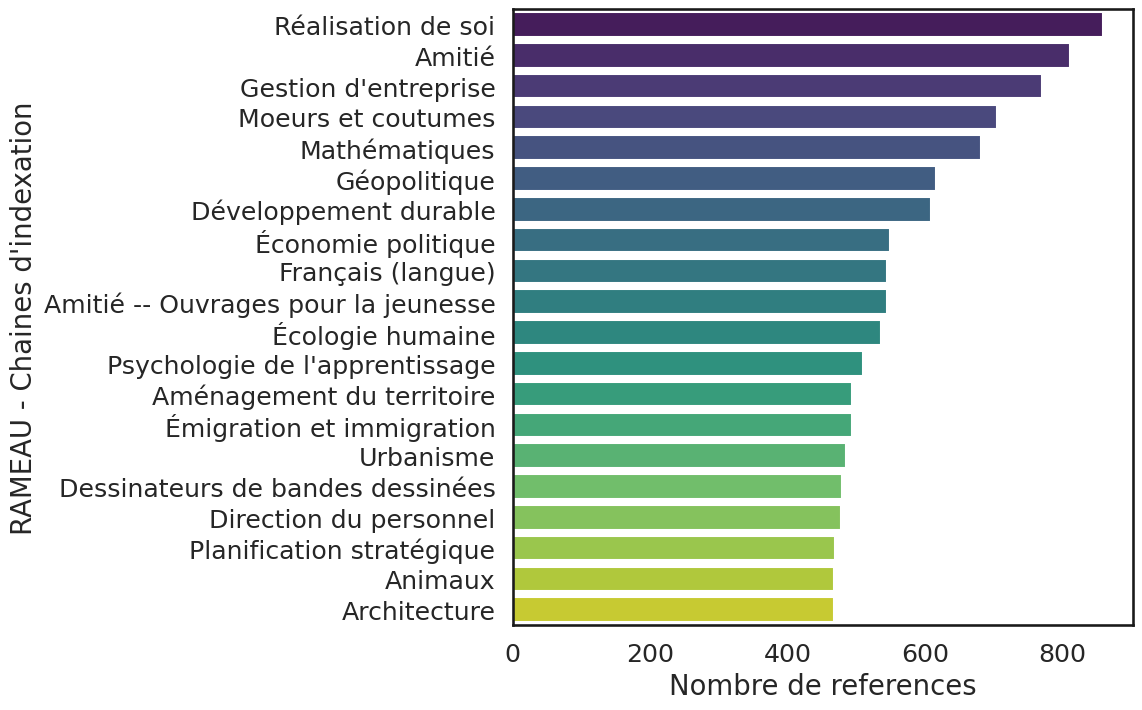

In [29]:
plot_barplot_of_tags(
    tags_list=rameau_list_chaines_index,
    nb_of_tags=20,
    xlabel="Nombre de references",
    ylabel="RAMEAU - Chaines d'indexation",
    figsave=str(filename + "_" + 'barplot_Rameau_ChainesIndex_after_cleaning.png'),
    figsize=(8, 8))

In [30]:
# Mettre à plat TOUS les mots clé
pattern = r';\s*(?![^()]*\))| -- '
df["rameau_concepts"] = df["RAMEAU_CHECKED"].apply(lambda x: re.split(pattern, x))
df.loc[1:20, ["RAMEAU", "RAMEAU_CHECKED","rameau_concepts"]]

,RAMEAU,RAMEAU_CHECKED,rameau_concepts
1,Complexe de castration;Psychanalyse;Rêves,Complexe de castration;Psychanalyse;Rêves,"[Complexe de castration, Psychanalyse, Rêves]"
2,Culture,Culture,[Culture]
3,Structuralisme,Structuralisme,[Structuralisme]
4,Science-fiction américaine -- Traductions fran...,Science-fiction américaine -- Traductions fran...,"[Science-fiction américaine, Traductions franç..."
5,Photographie,Photographie,[Photographie]
6,Agglomérations urbaines;Aménagement du territo...,Agglomérations urbaines;Aménagement du territo...,"[Agglomérations urbaines, Aménagement du terri..."
7,Tarots (cartes à jouer) -- Contes,Tarots (cartes à jouer) -- Contes,"[Tarots (cartes à jouer), Contes]"
8,Allégorie de la caverne;Différences entre sexe...,Allégorie de la caverne;Différences entre sexe...,"[Allégorie de la caverne, Différences entre se..."
9,Attachement;Mères et nourrissons;Personnalité ...,Attachement;Mères et nourrissons;Personnalité ...,"[Attachement, Mères et nourrissons, Personnali..."
10,Philosophes;Philosophie et sciences,Philosophes;Philosophie et sciences,"[Philosophes, Philosophie et sciences]"


In [31]:
keywords = flatten(df['rameau_concepts'])
print(f"Le dataset contient {len(set(keywords))} concepts RAMEAU differents")

Le dataset contient 25992 concepts RAMEAU differents


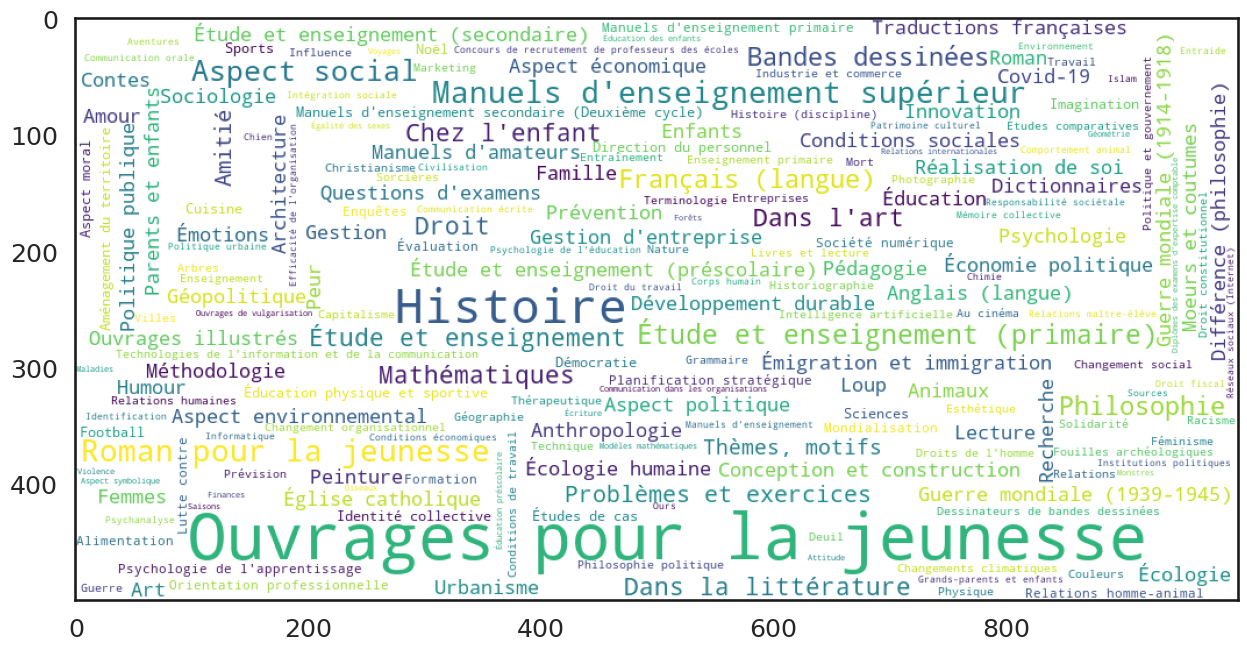

In [32]:
# Show main vedettes
plot_wordcloud(keywords, save_file=str(filename + "_" + "rameau_concepts_wordcloud_after_Cleaning.png"))

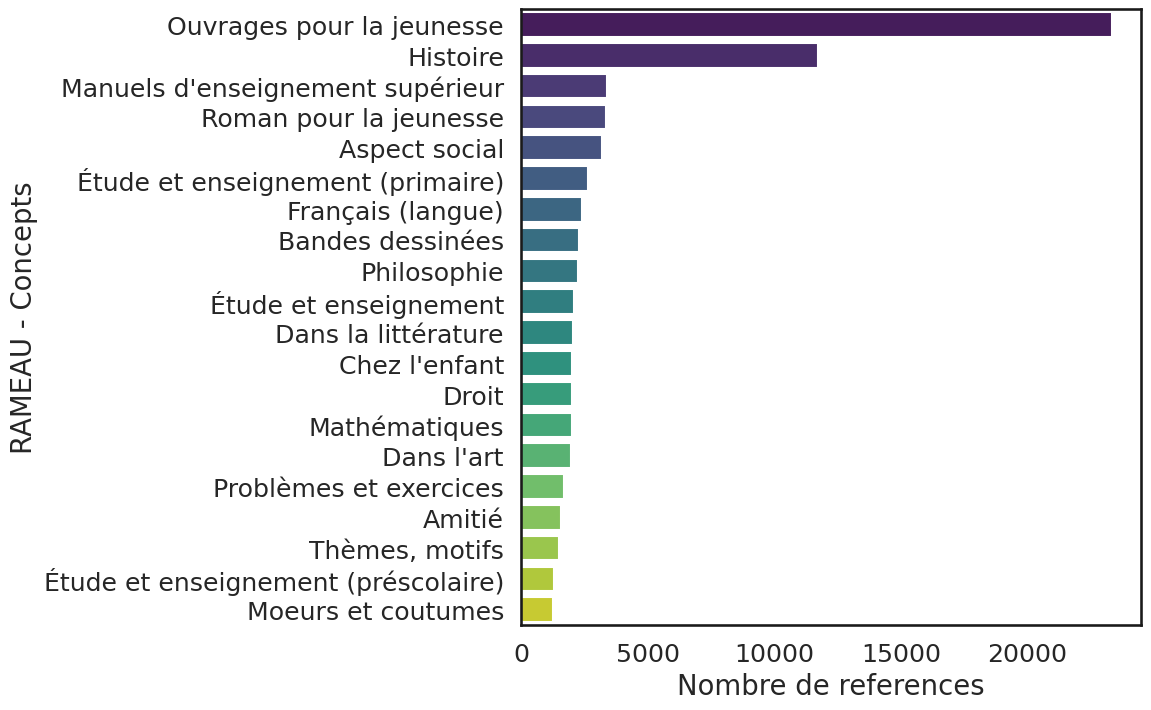

In [33]:
plot_barplot_of_tags(
    tags_list=keywords,
    nb_of_tags=20,
    xlabel="Nombre de references",
    ylabel="RAMEAU - Concepts",
    figsave=str(filename + "_" + 'barplot_Rameau_concepts_after_cleaning.png'),
    figsize=(8, 8))

### Remove vedettes

In [34]:
list_vedettes = ["Ouvrages pour la jeunesse", "Roman pour la jeunesse"]
colonne = "rameau_concepts"
temp = removeVedettes(df, colonne, list_vedettes)
temp.remove_vedette()

Nbre de notices contenant le concept 'Ouvrages pour la jeunesse' : 13293
Nbre de notices contenant le concept 'Roman pour la jeunesse' : 1949
Les vedettes de ['Ouvrages pour la jeunesse', 'Roman pour la jeunesse'] ont été retirées du dataset
Le dataset contient maintenant 154508 notices


### Check cleaned file

In [35]:
# Dataset final
cleaned_df = temp.df_reduced
cleaned_df.shape

(154508, 10)

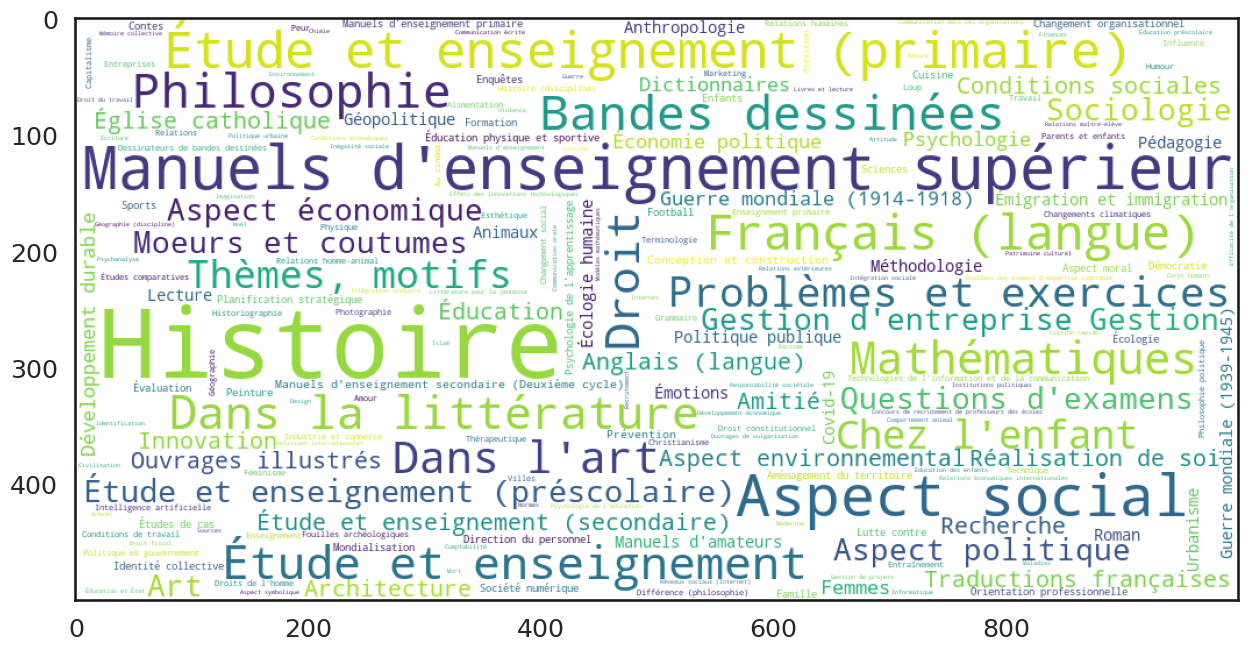

In [36]:
# Show main vedettes
keywords2 = flatten(cleaned_df['rameau_concepts'])
plot_wordcloud(keywords2, save_file=str(filename + "_" + "rameau_concepts_wordcloud_after_cleaning_cleaned.png"))

In [37]:
print(f"{len(keywords2)} concepts rameau, dont {len(set(keywords2))} différents")

449688 concepts rameau, dont 25717 différents


In [38]:
# Nombre de de notices d'autorité différentes (y compris pré-construites)
# ex d'autorité preconstruite : Science-fiction américaine -- Traductions française
from itertools import chain
rameau_chaine_index = cleaned_df["rameau_chaines_index"].tolist()
rameau_list_chaines_index = list(chain(*rameau_chaine_index))
print(f"{len(rameau_list_chaines_index)} chaines d'indexation rameau, dont {len(set(rameau_list_chaines_index))} différentes")

347988 chaines d'indexation rameau, dont 68674 différentes


In [39]:
# Bilan des notices contenant des chaines d'indexation avec plusieurs concepts
nb_chaines_index = cleaned_df["presence_chaine_indexation"].sum()
print(f"Parmi les notices, {nb_chaines_index} contiennent des chaines d'indexation avec plusieurs autorités RAMEAU")

Parmi les notices, 58559 contiennent des chaines d'indexation avec plusieurs autorités RAMEAU


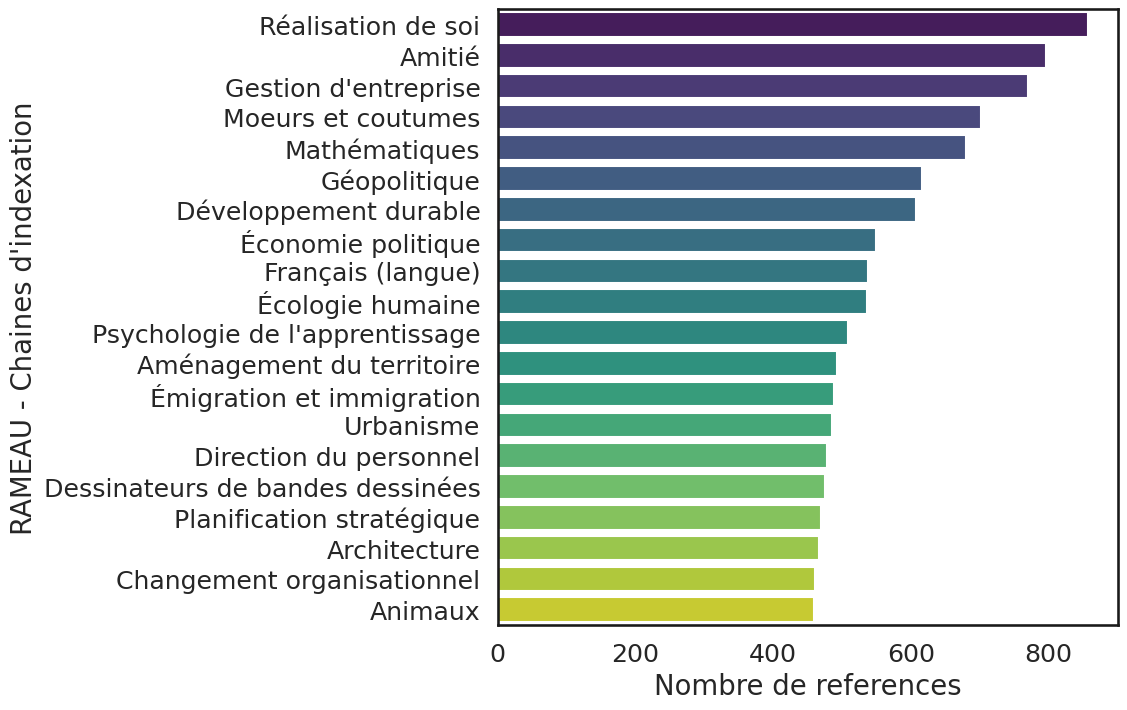

In [40]:
plot_barplot_of_tags(
    tags_list=rameau_list_chaines_index,
    nb_of_tags=20,
    xlabel="Nombre de references",
    ylabel="RAMEAU - Chaines d'indexation",
    figsave=str(filename + "_" + 'barplot_Rameau_ChainesIndex_after_cleaning_cleaned.png'),
    figsize=(8, 8))

### Explore Dewey

In [136]:
if merge_with_dewey:
    # Find DDC domain
    cleaned_df["DDC"] = cleaned_df["DEWEY"].apply(lambda x: get_domain_from_ddc(x))
    # Merge with TEF labels
    ddc = pd.read_csv(os.path.join(data_path, "dewey_label.csv"), index_col=0, dtype=str)

    # Merge 
    cleaned_df = cleaned_df.merge(ddc, on="DDC", how='left')
    print(f"Dimension of the dataframe with TEF labels: {cleaned_df.shape}")
    print("Column headers: ", list(cleaned_df.columns))

    # Visualization
    plot_barplot_of_tags(
        tags_list=cleaned_df["TEF_LABEL"],
        nb_of_tags=20,
        xlabel="Nombre de references",
        ylabel="Libellés TEF",
        figsave='barplot_libelles_TEF.png',
        figsize=(8, 8))

# Save working file as pickle

In [41]:
# Saving file
if working_data_filename.endswith(("pkl", "pickle")):
    cleaned_df.to_pickle(os.path.join(data_path, working_data_filename))
elif working_data_filename.endswith("csv"):
    cleaned_df.to_csv(os.path.join(data_path, working_data_filename))
else: 
    print("saved files must be .csv or .pickle")

In [42]:
## Export data for Lausanne
df_export = cleaned_df.copy()
df_export[["PPN", "TITRE", "RESUME", "RAMEAU_CHECKED"]].to_pickle("export_data_26062023.pkl")
t = pd.read_pickle("export_data_26062023.pkl")
print("Dimension du jeu de données :", t.shape)
t.head(3)

Dimension du jeu de données : (154508, 4)


,PPN,TITRE,RESUME,RAMEAU_CHECKED
0,000002364,La culture pour vivre,Mort de la culture populaire en France. Mutati...,Culture populaire;Diffusion de la culture;Poli...
1,000014877,"La nuit, le jour : essai psychanalytique sur l...","Discontinuité, latence, rétablissement d’une c...",Complexe de castration;Psychanalyse;Rêves
2,000021857,"Ruptures, cultures","Il faut imaginer Robinson sur son île, au mome...",Culture


# Create train, test and validation datasets

In [43]:
# Define file paths
train_ppn_file = "training_data.xlsx"
test_ppn_file = "testing_data.xlsx"
valid_ppn_file_100 = "reindexation_final_juin2023.csv"

In [44]:
# Define train and test sets 
train_set_ppn = pd.read_excel(os.path.join(data_path, train_ppn_file), dtype=str)
print("dimension of train set: ", train_set_ppn.shape)
test_set_ppn = pd.read_excel(os.path.join(data_path, test_ppn_file), dtype=str)
print("dimension of test set: ", test_set_ppn.shape)
valid_set_ppn = pd.read_csv(os.path.join(data_path, valid_ppn_file_100), index_col=0)
print("dimension of validation set: ", valid_set_ppn.shape)

dimension of train set:  (125264, 1)
dimension of test set:  (29244, 1)
dimension of validation set:  (100, 16)


In [45]:
# Reformatage des PPN commencant par des 0
ppn_size = 9
test_set_ppn["PPN"] = test_set_ppn["PPN"].str.zfill(ppn_size)
train_set_ppn["PPN"] = train_set_ppn["PPN"].str.zfill(ppn_size)

In [46]:
cleaned_df.head(5)

,PPN,TITRE,RESUME,RAMEAU,DEWEY,DESCR,RAMEAU_CHECKED,presence_chaine_indexation,rameau_chaines_index,rameau_concepts
0,000002364,La culture pour vivre,Mort de la culture populaire en France. Mutati...,Culture populaire;Diffusion de la culture;Poli...,840,La culture pour vivre Mort de la culture popul...,Culture populaire;Diffusion de la culture;Poli...,False,"[Culture populaire, Diffusion de la culture, P...","[Culture populaire, Diffusion de la culture, P..."
1,000014877,"La nuit, le jour : essai psychanalytique sur l...","Discontinuité, latence, rétablissement d’une c...",Complexe de castration;Psychanalyse;Rêves,154.63,"La nuit, le jour : essai psychanalytique sur l...",Complexe de castration;Psychanalyse;Rêves,False,"[Complexe de castration, Psychanalyse, Rêves]","[Complexe de castration, Psychanalyse, Rêves]"
2,000021857,"Ruptures, cultures","Il faut imaginer Robinson sur son île, au mome...",Culture,840,"Ruptures, cultures Il faut imaginer Robinson s...",Culture,False,[Culture],[Culture]
3,00002564X,La révolution structurale,"Mutations ou crises, les brusques accès de fiè...",Structuralisme,100,"La révolution structurale Mutations ou crises,...",Structuralisme,False,[Structuralisme],[Structuralisme]
4,000026352,La Destruction du temple,"Oswald tire sur Kennedy. Jusque-là, c'est bon,...",Science-fiction américaine -- Traductions fran...,830,La Destruction du temple Oswald tire sur Kenne...,Science-fiction américaine -- Traductions fran...,True,[Science-fiction américaine -- Traductions fra...,"[Science-fiction américaine, Traductions franç..."


In [47]:
# Define sets
df_train = pd.merge(cleaned_df, train_set_ppn, on="PPN", how="inner")
print("dimension of train set: ", df_train.shape)
df_test = pd.merge(cleaned_df, test_set_ppn, on="PPN", how="inner")
print("dimension of test set: ", df_test.shape)
df_valid = pd.merge(cleaned_df, valid_set_ppn["PPN"], on="PPN", how="inner")
print("dimension of test set: ", df_valid.shape)

dimension of train set:  (125264, 10)
dimension of test set:  (29244, 10)
dimension of test set:  (100, 10)


In [48]:
# Save train, test and validation sets en csv
df_train.to_csv(os.path.join(data_path, "train_dataset.csv"), index=0)
df_test.to_csv(os.path.join(data_path, "test_dataset.csv"), index=0)
df_valid.to_csv(os.path.join(data_path, "valid100_dataset.csv"), index=0)

In [49]:
# Save train, test and validation sets en pickle
df_train.to_pickle(os.path.join(data_path, "train_dataset.pkl"))
df_test.to_pickle(os.path.join(data_path, "test_dataset.pkl"))
df_valid.to_pickle(os.path.join(data_path, "valid100_dataset.pkl"))